# How to use numpy images with fastai (also my first time using fastai)

This short tutorial was intended to help me learn more about [fastai](https://www.fast.ai). Here I'll show you how to load in numpy images for for training. I decided to pick the original [MNIST](http://yann.lecun.com/exdb/mnist) dataset, for its small size and simplicity. I won't be using fastai's built in dataset loader for MNIST. 

Not going to lie, this one took me a while to figure out! For me there was a bit of a learning curve despite having gone through the book, tutorials and forum. If you have a PyTorch background (I don't) this library will probably come natural to you. There were plenty of gotchas and trial and error I experienced before arriving at a solution I was happy with, which I'll mention along the way. Anyway, I hope this tutorial saves you some headache if you're just starting out like me! 

This Jupyter notebook can be downloaded here https://github.com/nghiaho12/fastai_projects/blob/main/mnist.ipynb 

# Table of Contents
1. [Load the MNIST data](#load)
2. [Setup DataBlock](#data)
3. [Train the model](#train)
4. [Evaluate the model on the test set](#eval)
5. [Thoughts](#thoughts)

# 1. Load the MNIST data <a name="load"></a>
This will download the MNIST data and read them as a numpy array, stored in their original data type. The MNIST dataset consts of 70,000 handwritten digits from 0 to 9. 60,000 for training and 10,000 for testing. Each digit is a tiny grayscale 28x28 image.

I also check to make sure we're using a CUDA enabled GPU early on before doing anything else. On my Linux laptop I have to manually load the nvidia drivers to enable CUDA. fastai/PyTorch however will happily run on the CPU if you don't have a CUDA enabled GPU. This gotcha took me a while to notice!

In [1]:
from fastai.vision.all import *
import numpy as np
import gzip

# I'm using a dark theme for my Jupter Lab
plt.style.use('dark_background')

# Make sure we using the GPU
print("torch.cuda.device_count():", torch.cuda.device_count())
print("torch.cuda.current_device():", torch.cuda.current_device())
print("torch.cuda.get_device_name(0):", torch.cuda.get_device_name(0))

if torch.cuda.is_available() == False:
    raise ValueError("No CUDA device found!")

def read_mnist_image(file):
    with gzip.open(file, 'r') as f:
        f.read(4) # magic number
        num_images = int.from_bytes(f.read(4), byteorder='big')
        image_height = int.from_bytes(f.read(4), byteorder='big')
        image_width = int.from_bytes(f.read(4), byteorder='big')

        buf = f.read(image_width * image_height * num_images)
        data = np.frombuffer(buf, dtype=np.uint8)
        data = data.reshape(num_images, image_height, image_width)
        
        return data
    
def read_mnist_label(file):
    with gzip.open(file, 'r') as f:
        f.read(4) # magic number
        num_labels = int.from_bytes(f.read(4), byteorder='big')
        buf = f.read(num_labels)
        data = np.frombuffer(buf, dtype=np.uint8)

        return data
    
# download dataset if it doesn't exist    
files = ['train-images-idx3-ubyte.gz', 
         'train-labels-idx1-ubyte.gz', 
         't10k-images-idx3-ubyte.gz', 
         't10k-labels-idx1-ubyte.gz']

for f in files:
    if not os.path.exists(f):        
        url = 'http://yann.lecun.com/exdb/mnist/' + f
        print(url)
        download_url(url, f)
        
train_image = read_mnist_image('train-images-idx3-ubyte.gz')
train_label = read_mnist_label('train-labels-idx1-ubyte.gz')
test_image = read_mnist_image('t10k-images-idx3-ubyte.gz')
test_label = read_mnist_label('t10k-labels-idx1-ubyte.gz')

print("train_image:", train_image.shape)
print("train_label:", train_label.shape)
print("test_image:", test_image.shape)
print("test_label:", test_label.shape)

torch.cuda.device_count(): 1
torch.cuda.current_device(): 0
torch.cuda.get_device_name(0): GeForce MX250
train_image: (60000, 28, 28)
train_label: (60000,)
test_image: (10000, 28, 28)
test_label: (10000,)


# 2. Setup DataBlock <a name="data"></a>
Next we need to get the numpy array into the DataLoaders class. I spent most of my time at this step. I originally started with the tutorial [Using fastai on a custom new task](https://docs.fast.ai/tutorial.siamese.html). I got it working enough to do training but noticed other functionalities later on did not work (eg. plot_top_losses). It felt like too effort was required to figure out how to implement it correctly. I decided to go back to the DataBlock instead. I figured if you can get it working with a DataBlock everything else should magically work without a problem.

All the examples I've seen using the DataBlock involves loading files from the disk. Typically, the user passes in a folder to the dataloders class. The folder gets consumed by get_items, which returns a list of file path. Each file path is passed to get_x() and get_y(). get_x() loads the image, and get_y() figures out the label based on the file path. But the DataLoader is actually agnostic to the input datatype, as you provide your own functions to process it. So I came up wth this way of passing in a numpy array. This is much shorter and cleaner than using the low or mid level api.

The DataLoaders will automatically split your dataset into a training (80%) and validation set (20%).

Calling dls.show_batch() will randomly display a bunch of digits. This gives me some peace of mind that I loaded the data correctly.

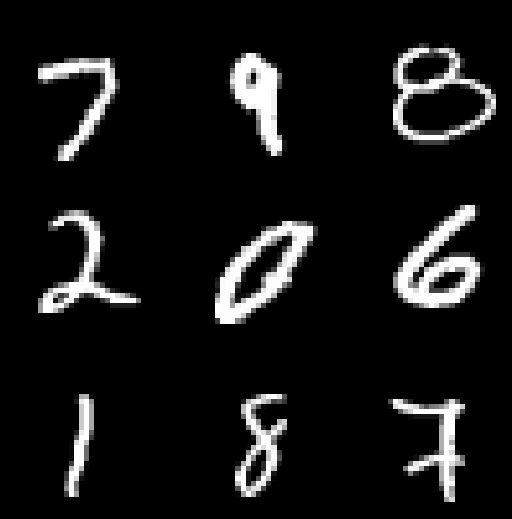

In [2]:
def make_dataloaders_from_numpy_data(image, label):
    def pass_index(idx):
        return idx

    def get_x(i):
        # NOTE: This is a grayscale image that appears to just work with a network expecting RGB.
        # I suspect this is due to tensor broadcasting rules.
        return image[i]

    def get_y(i):
        return label[i]

    dblock = DataBlock(
        blocks=(ImageBlock, CategoryBlock),
        get_items=pass_index,
        get_x=get_x,
        get_y=get_y)

    # pass in a list of index
    num_images = image.shape[0]
    dls = dblock.dataloaders(list(range(num_images)))

    return dls

dls = make_dataloaders_from_numpy_data(train_image, train_label)

# sanity check
dls.show_batch(cmap='gray')

# 3. Train the model <a name="train">
We're now ready to train the model. Here I do transfer learning on a pre-trained resnet18 model.

In [4]:
learn = cnn_learner(dls, models.resnet18, loss_func=CrossEntropyLossFlat(), metrics=accuracy)
learn.fine_tune(10)
learn.save("mnist_model")

epoch,train_loss,valid_loss,accuracy,time
0,0.772904,0.535107,0.832667,00:35


epoch,train_loss,valid_loss,accuracy,time
0,0.170616,0.097153,0.970167,00:59
1,0.099490,0.064003,0.980500,00:59
2,0.083470,0.047296,0.986667,01:00
3,0.054970,0.043560,0.988750,01:00
4,0.039767,0.035734,0.990083,01:00
5,0.028765,0.033438,0.991333,01:00
6,0.017267,0.032579,0.991750,01:00
7,0.007190,0.030381,0.992917,01:00
8,0.002644,0.030588,0.993333,01:00
9,0.003106,0.031376,0.992750,01:00


Path('models/mnist_model.pth')

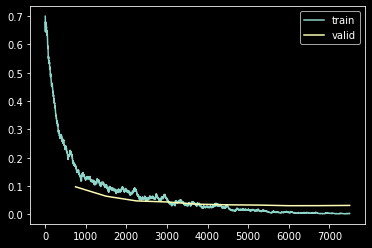

In [6]:
learn.recorder.plot_loss()

The accuracy is around 99.2%. The training and validation losses follow each other closely. Overall, pretty good results.

# 4. Evaluate model on test set <a name="eval">
To load the save model you re-create the same cnn_leaner as before, then call load. I haven't explored using export() yet. But maybe that would save you having to replicate the cnn_learner parameters.
    
We can now run inference on the test set. This one took a bit of time to figure out. I thought learn.predict() was the way to go but that only predicts for a single item (?). Instead you have to do this, which I find a bit convoluted.

In [9]:
learn = cnn_learner(dls, models.resnet18, loss_func=CrossEntropyLossFlat(), metrics=accuracy)
learn = learn.load("mnist_model")

pred = learn.get_preds(dl=dls.test_dl(test_image))
accuracy(pred[0], Tensor(test_label)).item()

0.9919999837875366

Good accuracy on the test set as well. For fun we can plot the confusion matrix and display some of the misclassification. You can see some of these digits are hard to recognize even for a human!

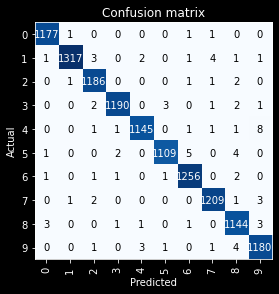

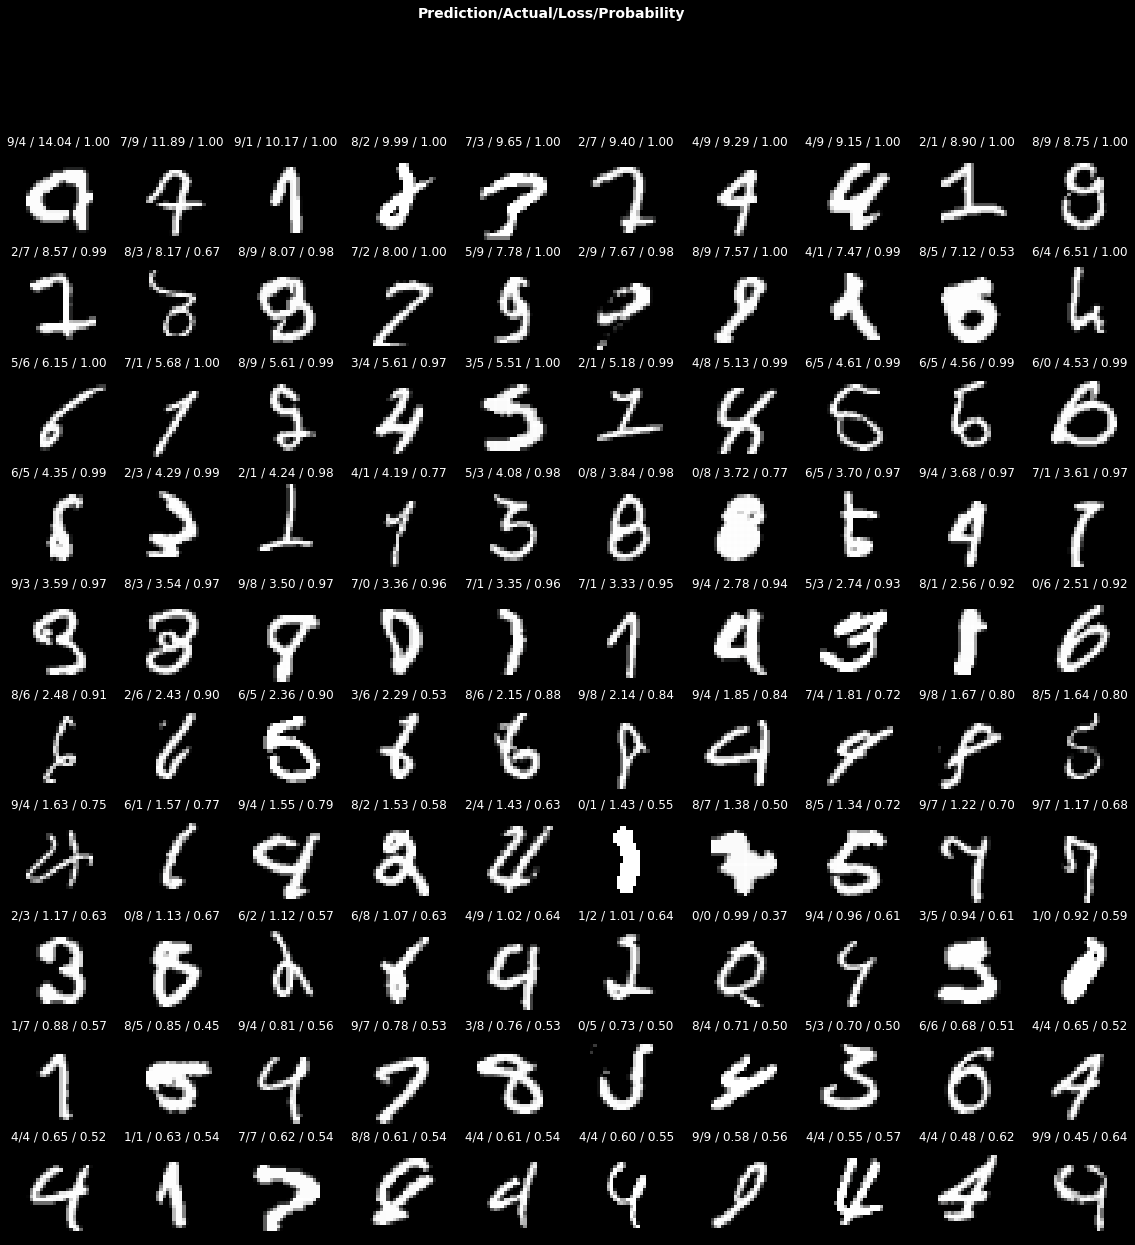

In [10]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()
interp.plot_top_losses(100, figsize=(20,20))

# 5. Thoughts <a name="thoughts"></a>
As a beginner, I found it difficult to figure out how to load in custom data. It took me some time to have a mental image in my head of all the pieces required and how they all fit together. I found the online documentation UI a bit annoying. You can only view one topic at a time on the sidebar. I prefer it when I can see every topic in one page and just scroll up and down.

However, once you get pass the data loading hurdles, training and analysis is pretty simple to get up and running. In fact, most of the code in this tutorial is just on loading the data into the right format! The training part requires writing very little code to get good results.

MNIST is an old school dataset that is really easy to get near perfect results on without trying too hard. In this case I took a an existing pre-trained resnet18 model and performed some fine tuning. No further tricks were necessary. It also shows the power of transfer learning.